<a href="https://colab.research.google.com/github/WeiKuoLi/Picture-Interpolation/blob/main/GANqr_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by taking care of the environment

QR CODE GENERATOR


try something

In [1]:
import numpy as np


In [2]:
import matplotlib.pyplot as plt


 

# **Data Preperation: Generate N Set of QR Codes and Decoded Binaries**
* Be careful during generating QR code at gen_qr, QR code is resized to 29*29.
* Also every thing needs to be float32 numpy array with correct dimensions or pytorch crashes.
* pil2array renormalized to 0-1 (originally 0-255)
* Change parameters here.

In [3]:
import random
N= 30000
box_len_qr = 29
bit_array_len = 256
 

## Test resized QR code
The following try_qr is for testing.
The following QR codes are resized & normal QR codes, they look the same.

# **Start building Deep Neural Network**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

* Create my own data set from the provided super class Dataset
* DataLoader loads data into mini batches of 10% datas
* num_workers set to 2 for google colab GPU

In [5]:
 
#define a dataset class
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
         
    def __getitem__(self, index):
        return (torch.from_numpy(self.x_data[index]), torch.from_numpy(self.y_data[index]))
    
    def __len__ (self):
        return len(self.x_data)
 

In [6]:
ranx=np.where(np.random.rand(N,bit_array_len )<0.5,0.0,1.0).astype('float32')
rany=ranx
ranx_val=np.where(np.random.rand(int(N/5),bit_array_len )<0.5,0.0,1.0).astype('float32')
rany_val=ranx_val
print(type(ranx))

ran_dataset = NumpyDataset(ranx, rany)
ran_val_dataset = NumpyDataset(ranx_val, rany_val)
#create a data loader
#a mini batch is 10% data
ran_loader = DataLoader(ran_dataset, batch_size=int(N/12), shuffle=True, num_workers=2) 
ran_val_loader = DataLoader(ran_val_dataset, batch_size=int(N/5/12), shuffle=True, num_workers=2)

<class 'numpy.ndarray'>


Deep neural network for testing. We use this to make sure pytorch runs smooth like butter.

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN,self).__init__()
        self.dim = 1
        self.fc1 = nn.Linear(input_size,80)
        self.fc2 = nn.Linear(80,output_size)
        
    def forward(self,x):
       # print(x.shape)
        x = self.fc1(x)
        
      #  print(x.shape)
        x = F.relu(x) 
        x = self.fc2(x)
        
       # print(x.shape)
        x= torch.sigmoid(x)
        return x

In [8]:
import math


## **Convolutional Neural Network**
* a. input layer (batch,1,29,29)
* b. 1 layer of cnn
* c. follow by flattening & a linear layer
* d. output layer
-------------------------------------------------------------------
* ReLU is used for nonlinear activation in between linear layers.
* sigmoid is for nonlinear activation right before output.

In [9]:
 
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN,self).__init__()
        self.dim = 2
        self.fc1 = nn.Conv2d(1,80,5,stride=2,padding=2)
 
        self.fc2 = nn.Conv2d(80,8,5,stride=2,padding=2)
        self.fl1 = nn.Flatten()

        self.fc3 = nn.Linear(512,output_size)
        
        # Use batch normalization to improve model performance
        self.batch_norm = nn.BatchNorm2d(8)
        
        # Use weight regularization to reduce overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x):
         
       # print(x.shape)
        x = self.fc1(x)
        
      #  print(x.shape)
        x = F.relu(x)
 
        x = self.fc2(x)
        x = F.relu(x)
        
        # Use batch normalization and dropout to improve model performance
        x = self.batch_norm(x)
        x = self.dropout(x)
        
        x = self.fl1(x)
       # x= self.d(x)
        #print(x.shape)
        x = self.fc3(x)    
        x= torch.sigmoid(x)
        return x


In [10]:
class DECODER(nn.Module):
    def __init__(self, input_size, output_size):
        super(DECODER,self).__init__()
        self.dim = 2
        self.fc1 = nn.Conv2d(1,80,5,stride=2,padding=2)
        self.fc2 = nn.Conv2d(80,8,5,stride=2,padding=2)
        self.fc3 = nn.Linear(512,output_size)

        # flattening to 1D
        self.fl1 = nn.Flatten() 
        
        # Use batch normalization to improve model performance
        self.batch_norm = nn.BatchNorm2d(8)
        
        # Use weight regularization to reduce overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x):
        #print("DECODING")
        x = self.fc1(x) 
        x = F.relu(x)
 
        x = self.fc2(x)
        x = F.relu(x)
        
        # Use batch normalization and dropout to improve model performance
        x = self.batch_norm(x)
        x = self.dropout(x)
        
        x = self.fl1(x) 
        x = self.fc3(x)    
        x= torch.sigmoid(x)
        return x


In [11]:
class ENCODER(nn.Module):
    def __init__(self, input_size, output_size):  
        super(ENCODER,self).__init__()
        self.dim = 2
        self.fc0 = nn.Linear(input_size,4*output_size*output_size)
        self.fc1 = nn.Conv2d(1,8,5,stride=2,padding=2)
        self.fc2 = nn.Conv2d(8,1,1)#,stride=2,padding=2)
        
        # flattening to 1D
        self.ufl1 = nn.Unflatten(1, (1,2*output_size, 2*output_size))
        
        # Use batch normalization to improve model performance
        self.batch_norm = nn.BatchNorm2d(8)
        
        # Use weight regularization to reduce overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x):
        #print(x.shape)
        x = self.fc0(x)
        #print(x.shape)
        x = self.ufl1(x) 
        #print(x.shape)

        x = self.fc1(x) 
        x = F.relu(x)
        #print(x.shape)
        # Use batch normalization and dropout to improve model performance
        x = self.batch_norm(x)
        x = self.dropout(x)
 
        x = self.fc2(x)
        x= torch.sigmoid(x)
        #print(x.shape)
        return x


In [12]:
class GAN(nn.Module):
    def __init__(self, ENCODER, DECODER):
        super(GAN, self).__init__()
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def forward(self, x):
        # Generate fake data
        gan_qr  = self.ENCODER(x)
        
        # Classify the fake data using the discriminator
        code = self.DECODER(gan_qr)
        
        return code

For gpu, not sure if AMD Radeon is usable. Here we use nvidia GPU.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
print(box_len_qr, bit_array_len)
model_en=ENCODER(input_size=bit_array_len,output_size=box_len_qr).to(device)
model_de=DECODER(input_size=box_len_qr,output_size=bit_array_len).to(device)
model_gan=GAN(ENCODER=model_en,DECODER=model_de).to(device)

#model=CNN(input_size=box_len_qr*box_len_qr,output_size=bit_array_len ).to(device)

29 256


In [22]:
learn_rate=0.00005 #0.0005 ~ 0.00001
num_epochs = 100

In [23]:
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gan.parameters(),lr=learn_rate,weight_decay=0.005)

#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

##Training starts here.

* Input data requires reshaping, since only one channel shape is (batch,1,29,29)
* Function data.to(device=device) can only happen after reshaping because gpu is distributed system.
* The tensor scores is a 2d tensor shaped (batch,24), same as targets
* MSE loss needs to be less than 0.01 for okay results 

In [24]:
for epoch in range(num_epochs):
    # Accumulate the losses for all the batches in the epoch
    train_losses = []
    val_losses = []
    for batch_idx, (data,targets) in enumerate(ran_loader):
 
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model_gan(data)
        loss = criterion(scores, targets)
        
        # Accumulate the loss for the batch
        train_losses.append(loss.mean())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

    # Compute the average loss for the training data
    avg_train_loss = sum(train_losses) / len(train_losses)

    # Compute the loss for the validation data
    with torch.no_grad():
        for batch_idx, (data,targets) in enumerate(ran_val_loader):
 
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model_gan(data)
            loss = criterion(scores, targets)

            # Accumulate the loss for the batch
            val_losses.append(loss.mean())

    # Compute the average loss for the validation data
    avg_val_loss = sum(val_losses) / len(val_losses)
    print("epoch ",epoch,"/",num_epochs," loss = ", float(avg_train_loss), "val_loss = ", float(avg_val_loss))


epoch  0 / 100  loss =  0.6021183133125305 val_loss =  0.5894160866737366
epoch  1 / 100  loss =  0.5746530294418335 val_loss =  0.5619893074035645
epoch  2 / 100  loss =  0.5457795858383179 val_loss =  0.5326912999153137
epoch  3 / 100  loss =  0.5157105326652527 val_loss =  0.5031963586807251
epoch  4 / 100  loss =  0.48582613468170166 val_loss =  0.4741705060005188
epoch  5 / 100  loss =  0.4567384719848633 val_loss =  0.4460396468639374
epoch  6 / 100  loss =  0.42851611971855164 val_loss =  0.4186774492263794
epoch  7 / 100  loss =  0.40126320719718933 val_loss =  0.3924301862716675
epoch  8 / 100  loss =  0.375221848487854 val_loss =  0.3673291802406311
epoch  9 / 100  loss =  0.3504273295402527 val_loss =  0.34344416856765747
epoch  10 / 100  loss =  0.3268115818500519 val_loss =  0.32067760825157166
epoch  11 / 100  loss =  0.3043869137763977 val_loss =  0.2990872263908386
epoch  12 / 100  loss =  0.28332969546318054 val_loss =  0.27888810634613037
epoch  13 / 100  loss =  0.26

* The function check_acc is for calculating correct rate.
* Gradient calculation is turned off because it is not needed.
* Reshape x for cnn, than copy to gpu.
* calculate num_correct for each mini batch
* Calculate ACC for final averaged score.

In [25]:
def acc(scores, y):
    tmp=torch.le(scores,0.5)   # true if lesser than 0.5 element wise   
    tmp2=(tmp==1-y.to(torch.int32))
 
    #print ((scores[0]*1).to(torch.float32),y[0])
    #print (torch.all(tmp,dim=1)) 
    return  (torch.all(tmp2,dim=1))
    
def check_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device)
            y = y.to(device=device)
           # print(x.shape)
            scores = model(x) 
          #  print(scores.shape)
            num_samples += x.shape[0]
            num_correct += (acc(scores,y)).sum()
            print(x.shape[0],(acc(scores,y)).sum())
        print("ACC = ", int(float(num_correct)/float(num_samples)*100)," %")

In [19]:
a = torch.rand(4, 2).bool()
torch.all(a, dim=1)
    

tensor([True, True, True, True])

In [26]:
print("TRAIN")
check_acc(ran_loader, model_gan)

 

print("VAL")
check_acc(ran_val_loader, model_gan)

TRAIN
2500 tensor(2487, device='cuda:0')
2500 tensor(2481, device='cuda:0')
2500 tensor(2487, device='cuda:0')
2500 tensor(2489, device='cuda:0')
2500 tensor(2486, device='cuda:0')
2500 tensor(2484, device='cuda:0')
2500 tensor(2487, device='cuda:0')
2500 tensor(2486, device='cuda:0')
2500 tensor(2490, device='cuda:0')
2500 tensor(2476, device='cuda:0')
2500 tensor(2493, device='cuda:0')
2500 tensor(2485, device='cuda:0')
ACC =  99  %
VAL
500 tensor(477, device='cuda:0')
500 tensor(478, device='cuda:0')
500 tensor(468, device='cuda:0')
500 tensor(475, device='cuda:0')
500 tensor(475, device='cuda:0')
500 tensor(483, device='cuda:0')
500 tensor(480, device='cuda:0')
500 tensor(482, device='cuda:0')
500 tensor(480, device='cuda:0')
500 tensor(478, device='cuda:0')
500 tensor(481, device='cuda:0')
500 tensor(483, device='cuda:0')
ACC =  95  %


## **Show GAN result**

torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])
torch.Size([500, 1, 29, 29])


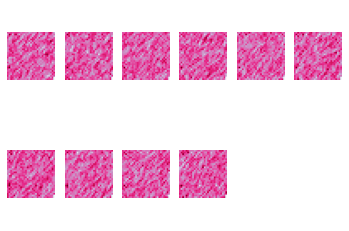

In [21]:
def draw_gan(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    pic=[]
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device)
            y = y.to(device=device)
           # print(x.shape)
            scores = model(x) 
            #plt.imshow(scores[0].cpu().reshape(29,29),cmap='gray')
            print(scores.shape)
            if(np.random.random()<.6):
                pic.append(np.array(scores[0].cpu().reshape(29,29)))
    return pic

def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure()
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.axis('off')
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(2, n/2+1, i + 1)
        fig=plt.imshow(images[i],cmap='PuRd')
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.show(block=True)             


show_images((draw_gan(ran_val_loader,model_en)))   

# **Conclusion**
* data size matters, N~20000 gives okay results
* keep the model simple
* input space scales as $2^{dim^2}$, output space scales as $2^{dim}$
* Neural network is a really bad choice of algorithm. Because there is a exponentionally growing of class number(since we treat this as a classifying task)

 


# **TODO**
* Mixing of traditional decoder algorithm may be fun.
* Or maybe just give up this project.